The purpose of this notebook is to use historical comparisons of similar companies to project the one-year growth of a given company, defined as the difference between sales at point t+12 and point t where t is the end of the known time series.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from math import floor, sqrt
from dtw import dtw
from fastdtw import fastdtw

# Modeling
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Visualizations
import matplotlib.pyplot as plt

# Statistics
from statsmodels.tsa.stattools import adfuller
from scipy.stats import t

# Utilies
from tqdm import tqdm

# Data cleaning and exploration

In this section, we read in the data and calculate the monthly retention rates by company.

In [2]:
# Read in cohort data from each company
company_names = pd.ExcelFile('../data/Commerce analysis - full sales data.xlsx').sheet_names[1:]
print(company_names)
company_dfs = [pd.read_excel('../data/Commerce analysis - full sales data.xlsx', sheet_name = company) for company in tqdm(company_names)]
company_dfs = dict(zip(company_names, company_dfs))

['Blue Apron', 'Brandless', 'Chewy', 'Dollar Shave Club', 'Peloton', 'Ring', 'Stitch Fix', 'Warby Parker', 'Wish']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.20it/s]


In [3]:
company_dfs['Blue Apron']

,Cohort month,Cohort size,1,2,3,4,5,6,7,8,...,64,65,66,67,68,69,70,71,72,73
0,2012-08-01,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
1,2012-09-01,3,1.0000,1.0000,0.3333,0.6667,0.3333,0.3333,0.3333,0.3333,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,NaN
2,2012-10-01,9,0.7778,0.7778,0.7778,0.7778,0.6667,0.5556,0.6667,0.5556,...,0.2222,0.2222,0.2222,0.1111,0.2222,0.1111,0.3333,0.3333,NaN,NaN
3,2012-11-01,8,0.8750,0.7500,0.5000,0.5000,0.3750,0.3750,0.2500,0.2500,...,0.0000,0.0000,0.0000,0.1250,0.0000,0.0000,0.0000,NaN,NaN,NaN
4,2012-12-01,8,0.6250,0.6250,0.6250,0.2500,0.2500,0.1250,0.3750,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
5,2013-01-01,25,0.7200,0.7200,0.6000,0.5600,0.4400,0.4400,0.2800,0.3600,...,0.0800,0.0800,0.0800,0.1200,0.1600,NaN,NaN,NaN,NaN,NaN
6,2013-02-01,39,0.8205,0.7436,0.4872,0.4615,0.3846,0.3846,0.3590,0.2821,...,0.1282,0.1282,0.1026,0.1026,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-03-01,82,0.7195,0.6098,0.4756,0.4268,0.4024,0.4756,0.3415,0.3049,...,0.0610,0.0610,0.0610,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-04-01,88,0.6818,0.6250,0.5000,0.4432,0.5341,0.3977,0.3636,0.2955,...,0.1591,0.1250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-05-01,62,0.5968,0.4677,0.4677,0.4194,0.3226,0.4032,0.3710,0.3548,...,0.0484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Convert strings to datetime
for company in company_names:
    company_dfs[company]['Cohort month'] = pd.to_datetime(company_dfs[company]['Cohort month'])

In [5]:
# Calculate cohort retention rate for later use
for company in company_names:
    cohort_return_array = np.array(company_dfs[company].iloc[:, 2:].multiply(company_dfs[company]['Cohort size'], axis = 0))
    # Fill in nan with 0 and flip diagonals
    cohort_return_array = np.fliplr(np.nan_to_num(cohort_return_array))
    company_dfs[company]['Repeat_customers'] = [np.nan] + \
                                               [np.trace(cohort_return_array, offset = i) for i in range(len(cohort_return_array) - 2, -1, -1)]
    company_dfs[company]['Retention_rate'] = company_dfs[company]['Repeat_customers'] / \
                                            (company_dfs[company]['Repeat_customers'].shift(1).fillna(0) + \
                                             company_dfs[company]['Cohort size'].shift(1))

In [6]:
company_dfs['Blue Apron'].head()

,Cohort month,Cohort size,1,2,3,4,5,6,7,8,...,66,67,68,69,70,71,72,73,Repeat_customers,Retention_rate
0,2012-08-01,1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,NaN,NaN
1,2012-09-01,3,1.0000,1.0000,0.3333,0.6667,0.3333,0.3333,0.3333,0.3333,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,NaN,1.0000,1.000000
2,2012-10-01,9,0.7778,0.7778,0.7778,0.7778,0.6667,0.5556,0.6667,0.5556,...,0.2222,0.1111,0.2222,0.1111,0.3333,0.3333,NaN,NaN,4.0000,1.000000
3,2012-11-01,8,0.8750,0.7500,0.5000,0.5000,0.3750,0.3750,0.2500,0.2500,...,0.0000,0.1250,0.0000,0.0000,0.0000,NaN,NaN,NaN,11.0002,0.846169
4,2012-12-01,8,0.6250,0.6250,0.6250,0.2500,0.2500,0.1250,0.3750,0.0000,...,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,16.0001,0.842102


In [7]:
# Read in company sales data
sales_df = pd.read_excel('../data/Commerce analysis - full sales data.xlsx', sheet_name = 'Sales')
print(sales_df.shape)
sales_df.head()

(837, 5)


,Company,Month,Sales,Customers,Transactions
0,Blue Apron,2011-01-01,0,0,0
1,Blue Apron,2011-02-01,0,0,0
2,Blue Apron,2011-03-01,0,0,0
3,Blue Apron,2011-04-01,0,0,0
4,Blue Apron,2011-05-01,0,0,0


In [8]:
sales_df.Month = pd.to_datetime(sales_df.Month)

In [9]:
# We could get these dates of first sales from the cohort tabs, but will approach this in a generalizable way
first_sales_dates = {}
for company in sales_df.Company.unique():
    first_sales_dates[company] = sales_df.Month[np.where((sales_df.Sales > 0) & (sales_df.Company == company))[0][0]]

In [10]:
sales_df['First_Month'] = [first_sales_dates[company] for company in sales_df.Company]
sales_df = sales_df[sales_df.Month >= sales_df.First_Month].reset_index(drop = True)
print(sales_df.shape)
sales_df.head()

(691, 6)


,Company,Month,Sales,Customers,Transactions,First_Month
0,Blue Apron,2012-08-01,56,1,1,2012-08-01
1,Blue Apron,2012-09-01,845,4,13,2012-08-01
2,Blue Apron,2012-10-01,2192,13,34,2012-08-01
3,Blue Apron,2012-11-01,2468,20,41,2012-08-01
4,Blue Apron,2012-12-01,2789,24,43,2012-08-01


In [11]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month
sales_df['Months_since_first'] = [diff_month(d1, d2) for d1, d2 in zip(sales_df['Month'], sales_df['First_Month'])]
sales_df['Months_since_first'].value_counts().head()

0     9
7     9
13    9
12    9
11    9
Name: Months_since_first, dtype: int64

In [12]:
sales_df['Quarters_since_first'] = [floor(x/3) for x in sales_df['Months_since_first']]
sales_df['Quarters_since_first'].value_counts().head()

0    27
1    27
2    27
3    27
4    27
Name: Quarters_since_first, dtype: int64

In [13]:
sales_df['Years_since_first'] = [floor(x/12) for x in sales_df['Months_since_first']]
sales_df['Years_since_first'].value_counts().head()

0    108
1     99
4     96
3     96
2     96
Name: Years_since_first, dtype: int64

In [14]:
sales_df['Monthly_revenue_per_cust'] = sales_df.Sales / sales_df.Customers

In [15]:
# Get retention rate data from cohort tabs of original Excel
retention_rates = []
for idx in tqdm(range(len(sales_df))):
    company = sales_df['Company'][idx]
    retention_rates.append(company_dfs[company]['Retention_rate'][company_dfs[company]['Cohort month'] == sales_df['Month'][idx]].values[0])

100%|██████████████████████████████████████████████████████████████████████████████| 691/691 [00:00<00:00, 1302.56it/s]


In [16]:
sales_df['Retention_rate'] = retention_rates
# Cap monthly retention rate at 98% for realistic lifetime value projections, higher is due to noise from returning lapsed members of earlier cohorts
cutoff = .98
print('Proportion of months with retention rate greater than cutoff of ' + str(cutoff) + ':',
      (sales_df['Retention_rate'] > cutoff).sum() / len(sales_df))
sales_df['Retention_rate'][sales_df['Retention_rate'] > cutoff] = cutoff
sales_df.head()

Proportion of months with retention rate greater than cutoff of 0.98: 0.04341534008683068


C:\Users\ezhang\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Company,Month,Sales,Customers,Transactions,First_Month,Months_since_first,Quarters_since_first,Years_since_first,Monthly_revenue_per_cust,Retention_rate
0,Blue Apron,2012-08-01,56,1,1,2012-08-01,0,0,0,56.000000,NaN
1,Blue Apron,2012-09-01,845,4,13,2012-08-01,1,0,0,211.250000,0.980000
2,Blue Apron,2012-10-01,2192,13,34,2012-08-01,2,0,0,168.615385,0.980000
3,Blue Apron,2012-11-01,2468,20,41,2012-08-01,3,1,0,123.400000,0.846169
4,Blue Apron,2012-12-01,2789,24,43,2012-08-01,4,1,0,116.208333,0.842102


In [17]:
# Ring data is messy due to long ramp-up period with single-digit cohort sizes
for company in company_names:
    print(company, 'proportion of retention rates reduced to', str(cutoff) + ':',
          (sales_df[sales_df.Company == company].Retention_rate == .98).sum() / (sales_df.Company == company).sum())

Blue Apron proportion of retention rates reduced to 0.98: 0.02702702702702703
Brandless proportion of retention rates reduced to 0.98: 0.0
Chewy proportion of retention rates reduced to 0.98: 0.047058823529411764
Dollar Shave Club proportion of retention rates reduced to 0.98: 0.08139534883720931
Peloton proportion of retention rates reduced to 0.98: 0.03076923076923077
Ring proportion of retention rates reduced to 0.98: 0.13978494623655913
Stitch Fix proportion of retention rates reduced to 0.98: 0.0
Warby Parker proportion of retention rates reduced to 0.98: 0.0
Wish proportion of retention rates reduced to 0.98: 0.021505376344086023


In [18]:
# Values have not changed much from previous approach just taking new vs. repeat customers
# This is probably because breaking down the cohort data does the same thing as looking at the overall new vs. repeat changes
# Subset minimum number of customers to 100 to avoid noisy early starts
sales_df[sales_df.Customers > 100].groupby('Company')['Retention_rate'].mean()

Company
Blue Apron           0.817230
Brandless            0.336653
Chewy                0.845284
Dollar Shave Club    0.926212
Peloton              0.853331
Ring                 0.671836
Stitch Fix           0.817453
Warby Parker         0.300812
Wish                 0.593625
Name: Retention_rate, dtype: float64

In [19]:
sales_df['CLV'] = sales_df.Monthly_revenue_per_cust * (1/(1-sales_df.Retention_rate))

In [20]:
sales_df.groupby('Company')['CLV'].mean()

Company
Blue Apron           1114.465039
Brandless              66.239734
Chewy                 796.809770
Dollar Shave Club     197.071515
Peloton              3339.511028
Ring                 1658.196389
Stitch Fix            710.533406
Warby Parker          217.799572
Wish                  244.081077
Name: CLV, dtype: float64

In [21]:
sales_df[sales_df.Months_since_first < 15].groupby('Company')['CLV'].mean()

Company
Blue Apron           2136.339520
Brandless              66.239734
Chewy                1178.200188
Dollar Shave Club      89.630529
Peloton              7722.904366
Ring                 2695.914141
Stitch Fix            200.153157
Warby Parker          127.068768
Wish                  766.231061
Name: CLV, dtype: float64

In [22]:
sales_df[sales_df.Company == 'Brandless']

,Company,Month,Sales,Customers,Transactions,First_Month,Months_since_first,Quarters_since_first,Years_since_first,Monthly_revenue_per_cust,Retention_rate,CLV
74,Brandless,2017-07-01,16768,419,459,2017-07-01,0,0,0,40.019093,NaN,NaN
75,Brandless,2017-08-01,15735,372,414,2017-07-01,1,0,0,42.298387,0.085900,46.273260
76,Brandless,2017-09-01,16048,311,352,2017-07-01,2,0,0,51.601286,0.188686,63.602154
77,Brandless,2017-10-01,18946,461,501,2017-07-01,3,1,0,41.097614,0.340862,62.350548
78,Brandless,2017-11-01,19536,455,502,2017-07-01,4,1,0,42.936264,0.332608,64.334440
79,Brandless,2017-12-01,19594,430,484,2017-07-01,5,1,0,45.567442,0.238940,59.873689
80,Brandless,2018-01-01,31500,782,857,2017-07-01,6,2,0,40.281330,0.417238,69.121361
81,Brandless,2018-02-01,30761,734,813,2017-07-01,7,2,0,41.908719,0.317563,61.410413
82,Brandless,2018-03-01,37395,857,970,2017-07-01,8,2,0,43.634772,0.350591,67.191525
83,Brandless,2018-04-01,46011,1130,1298,2017-07-01,9,3,0,40.717699,0.485946,79.208918


In [23]:
company_dfs['Brandless']

,Cohort month,Cohort size,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Repeat_customers,Retention_rate
0,2017-07-01,419,0.0859,0.0788,0.0764,0.0859,0.0453,0.0907,0.0573,0.0525,0.0835,0.1026,0.0501,0.0573,0.0382,0.0453,NaN,NaN
1,2017-08-01,335,0.1104,0.1224,0.0896,0.0507,0.0597,0.0478,0.0567,0.0776,0.0597,0.0358,0.0448,0.0448,0.0597,NaN,35.9921,0.085900
2,2017-09-01,241,0.1369,0.0954,0.0581,0.0664,0.0705,0.0747,0.1203,0.0913,0.0498,0.0498,0.0415,0.0539,NaN,NaN,70.0012,0.188686
3,2017-10-01,354,0.1808,0.0932,0.0847,0.0989,0.0621,0.0791,0.0706,0.0424,0.0621,0.0508,0.0565,NaN,NaN,NaN,106.0085,0.340862
4,2017-11-01,303,0.0858,0.1254,0.1419,0.1056,0.1221,0.0858,0.0693,0.0726,0.0594,0.0264,NaN,NaN,NaN,NaN,153.0027,0.332608
5,2017-12-01,320,0.1156,0.1281,0.0938,0.1500,0.1156,0.0688,0.0688,0.0656,0.0438,NaN,NaN,NaN,NaN,NaN,108.9575,0.238940
6,2018-01-01,602,0.1196,0.0864,0.0997,0.1080,0.0449,0.0498,0.0631,0.0449,NaN,NaN,NaN,NaN,NaN,NaN,178.9772,0.417238
7,2018-02-01,485,0.1278,0.1567,0.0887,0.0660,0.0536,0.0598,0.0515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0097,0.317563
8,2018-03-01,599,0.1285,0.1202,0.0634,0.0768,0.0434,0.0384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.9867,0.350591
9,2018-04-01,715,0.1259,0.0951,0.0587,0.0615,0.0503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.9629,0.485946


# Clustering

In this section we extract a set of similar company comparisons to use in model training.

In [24]:
class CandidateExtractor:
    """ This class can be used to identify the time series subsequence for each potential comparison company 
    with the smallest distance from the series to forecast that fits specified constraints
    
    Initial inputs:
        ts_to_match (np.array): contains the time series to forecast, monthly data points
        ts_candidates (list of np.arrays): contains the time series for the potential company comparisons, monthly data points
        candidate_names (list of str): contains the names of the candidates corresponding to ts_candidates, default numeric index
    """
    
    def __init__(self, ts_to_match, ts_candidates, candidate_names = None):
        self.forecast_lag_months = 12
        
        self.ts_to_match = ts_to_match
        # Assign names to track original candidate order relative to any sorted lists
        if not candidate_names:
            candidate_names = np.array(range(len(ts_candidates)))
            
        # Remove any candidates that are not long enough (and their corresponding names)
        ts_to_keep = np.where([len(ts) >= len(ts_to_match) + self.forecast_lag_months for ts in ts_candidates])[0]
        ts_candidates = np.array(ts_candidates)[ts_to_keep]
        self.candidate_names = np.array(candidate_names)[ts_to_keep]
        
        # Remove the last year of data points from each candidate since we do not have forecasts for those
        self.ts_candidates = np.array([ts[:-self.forecast_lag_months] for ts in ts_candidates])
        # Get values to forecast from same time series, excluding the length of the time series to predict and forecast lag
        self.forecast_vals = np.array([ts[len(ts_to_match) + self.forecast_lag_months - 1:] for ts in ts_candidates])
        
        # Set default indices for when `filter_ts_candidates` function is not used
        self.start_indices = [0] * len(ts_candidates)
        self.end_indices = [len(ts) for ts in ts_candidates]
        
    def filter_ts_candidates(self, min_val, max_val):
        """ Remove subsequences that do not meet criteria
        
        Inputs:
            min_val (int): time series subsequence must start and remain above this value
            max_val (int): time series subsequence must not go above this value
        """
        self.start_indices = []
        self.end_indices = []
        for ts in self.ts_candidates:
            try:
                start_idx = np.where(ts < min_val)[0][-1] + 1
            except IndexError:
                start_idx = 0
            try:
                end_idx = np.where(ts > max_val)[0][0]
            except IndexError:
                end_idx = len(ts)
            self.start_indices.append(start_idx)
            self.end_indices.append(end_idx)
        
        self.forecast_vals = [val[start_idx:end_idx] for val, start_idx, end_idx in zip(self.forecast_vals, 
                                                                                        self.start_indices,
                                                                                        self.end_indices)]
        self.ts_candidates = [ts[start_idx:end_idx] for ts, start_idx, end_idx in zip(self.ts_candidates, 
                                                                                      self.start_indices,
                                                                                      self.end_indices)]
        
        # Remove any candidates that are not long enough (and their corresponding names/forecasts) after filtering
        ts_to_keep = np.where([len(ts) >= len(self.ts_to_match) for ts in self.ts_candidates])[0]
        self.ts_candidates = np.array(self.ts_candidates)[ts_to_keep]
        self.candidate_names = np.array(self.candidate_names)[ts_to_keep]
        self.forecast_vals = np.array(self.forecast_vals)[ts_to_keep]
    
    def get_best_candidates(self, num_comps, norm = False, dtw = False):
        """ Extract the time series with the lowest distance to the time series to forecast
        
        Inputs:
            num_comps (int): number of time series subsequences to return, one per company comparison
            norm (bool): if True, normalize time series to forecast and candidates when calculating distance
            dtw (bool): if True, use dynamic-time-warping distance metric; else, use Euclidean default
        
        Returns:
            best_candidates (list of np. arrays): len of num_comps, contains best subsequences with same length as ts_to_match,
                                                  one per potential company comparison, sorted ascending by distance
            best_distances (list of floats): contains the distance values for each candidate
            best_indices (list of int duples): contains the indices of the best_candidates, to sync with other features (start, end)
            forecast_vals (list of floats): contains values to be used as truth for training forecasting model
            candidate_order (list of str): sorted to correspond to the order of the time series in best_candidates
        """
        # Generate all possible stepwise time series with the length of `ts_to_match`
        expanded_ts_candidates = []
        for ts, candidate_name in zip(self.ts_candidates, self.candidate_names):
            expanded_ts_candidates.append([ts[x:len(self.ts_to_match)+x] for x in range(len(ts)-len(self.ts_to_match)+1)])
        
        # Calculate distance, normalizing if specified, and get ts, indices, forecast values corresponding to the best distance
        best_candidates, best_distances, best_indices, forecast_vals = [], [], [], []
        for expansion, forecast_val, start_idx in zip(expanded_ts_candidates, self.forecast_vals, self.start_indices):
            if dtw:
                if norm:
                    dist = [sqrt(fastdtw(ts / ts[0], self.ts_to_match / self.ts_to_match[0])[0]) for ts in expansion]
                else:
                    dist = [sqrt(fastdtw(ts, self.ts_to_match)[0]) for ts in expansion]
            else:
                if norm:
                    dist = [np.linalg.norm(ts / ts[0] - self.ts_to_match / self.ts_to_match[0]) for ts in expansion] 
                else:
                    dist = [np.linalg.norm(ts - self.ts_to_match) for ts in expansion]
            best_candidate_idx = np.argmin(dist)
            best_candidates.append(expansion[best_candidate_idx])
            best_distances.append(np.min(dist))
            best_indices.append((start_idx + best_candidate_idx, 
                                 start_idx + best_candidate_idx + len(self.ts_to_match)))
            forecast_vals.append(forecast_val[best_candidate_idx])
        
        # Sort by the best distances, and return top num_comps time series and corresponding info
        sorted_tups = zip(*sorted(zip(best_distances, best_candidates, best_indices, forecast_vals, self.candidate_names)))
        best_distances, best_candidates, best_indices, forecast_vals, candidate_order = (list(tup)[:num_comps] for tup in sorted_tups)

        return best_candidates, best_distances, best_indices, forecast_vals, candidate_order

In [25]:
ts_to_match = sales_df.Sales[sales_df.Company == 'Brandless'].values
ts_to_match

array([16768, 15735, 16048, 18946, 19536, 19594, 31500, 30761, 37395,
       46011, 47722, 40644, 46352, 51401, 60968], dtype=int64)

In [26]:
company_names = pd.ExcelFile('../data/Commerce analysis - full sales data.xlsx').sheet_names[1:]
all_candidates = [sales_df.Sales[sales_df.Company == company].values for company in company_names]

In [27]:
candidate_extractor = CandidateExtractor(ts_to_match, all_candidates, company_names)

In [28]:
candidate_extractor.filter_ts_candidates(min_val = 1000, max_val = 300000)

In [29]:
# Let's look at an example
all_candidates[company_names.index('Dollar Shave Club')]

array([    51,     35,    116,     36,     10,      0,     33,  11761,
         8154,   5793,  16408,  17415,  20136,  18340,  20383,  21687,
        24270,  27109,  28323,  40923,  43225,  48420,  69039,  65505,
        71175,  77485,  90168, 100415, 123184, 124079, 135046, 150303,
       160170, 183118, 212665, 218037, 241871, 267507, 286168, 311897,
       357643, 358426, 384021, 399892, 405760, 430703, 477385, 443006,
       495057, 507661, 526611, 535740, 631862, 602596, 635721, 658208,
       627617, 664359, 697201, 663236, 657509, 648831, 657731, 670479,
       715005, 673264, 680065, 677669, 696508, 684084, 687385, 684613,
       672644, 671911, 666452, 678432, 672863, 653893, 663519, 651696,
       662740, 650534, 667514, 667898, 655907, 652795], dtype=int64)

In [30]:
# Spot-check filtering
candidate_extractor.ts_candidates[company_names.index('Dollar Shave Club')]

array([  1679,   3446,   3419,   4008,  11562,   6335,   5735,  40970,
        13916,   7390,  24288,  23780,  26173,  43737,  80094,  72286,
        66546,  52790,  52606,  51646,  62929,  57198,  82980,  97404,
       124771, 210130, 221569, 268983, 255384, 204015, 179896, 171415,
       143838, 145871, 129122, 219424, 227950], dtype=int64)

In [31]:
best_candidates, best_distances, best_indices, forecast_vals, candidate_order = \
candidate_extractor.get_best_candidates(5, norm = True, dtw = True)

In [32]:
# Spot-check forecast value - 495057 is the forecast value, 12 months after 241871, the end value of the first candidate
[print(label, output) for label, output in zip(['Best candidates:', 'Distances:', 'Indices:', 'Forecast values:', 'Companies:'],
                                               [best_candidates, best_distances, best_indices, forecast_vals, candidate_order])]

Best candidates: [array([ 69039,  65505,  71175,  77485,  90168, 100415, 123184, 124079,
       135046, 150303, 160170, 183118, 212665, 218037, 241871],
      dtype=int64), array([ 77896,  93099,  82349,  92402,  94792,  99588, 117678, 132455,
       123161, 153441, 163326, 175269, 222062, 225360, 269495],
      dtype=int64), array([25104, 27332, 31174, 30256, 32702, 26533, 44881, 41535, 53198,
       57608, 52714, 70847, 54720, 67600, 71038], dtype=int64), array([ 83798,  72762,  72028,  96091, 155053, 138219, 140816, 103993,
       129254, 164202, 205295, 210960, 210751, 246906, 241482],
      dtype=int64), array([ 72286,  66546,  52790,  52606,  51646,  62929,  57198,  82980,
        97404, 124771, 210130, 221569, 268983, 255384, 204015],
      dtype=int64)]
Distances: [1.3344397140055504, 1.5618695795051014, 1.594115444116491, 1.8754594433717564, 1.9299610480483254]
Indices: [(22, 37), (13, 28), (5, 20), (66, 81), (20, 35)]
Forecast values: [495057, 615869, 152879, 347405, 620232]


[None, None, None, None, None]

In [33]:
# Spot-check correct indexing - matches the above and is length 15 to match the amount of data we have for Brandless
all_candidates[company_names.index('Dollar Shave Club')][best_indices[0][0]:best_indices[0][1]]

array([ 69039,  65505,  71175,  77485,  90168, 100415, 123184, 124079,
       135046, 150303, 160170, 183118, 212665, 218037, 241871],
      dtype=int64)

In [34]:
# Results for non-normalized data
candidate_extractor.get_best_candidates(5, norm = False, dtw = True)

([array([15238, 18411, 20847, 21451, 24052, 25104, 27332, 31174, 30256,
         32702, 26533, 44881, 41535, 53198, 57608], dtype=int64),
  array([16408, 17415, 20136, 18340, 20383, 21687, 24270, 27109, 28323,
         40923, 43225, 48420, 69039, 65505, 71175], dtype=int64),
  array([ 6012,  3256,  7961, 15264, 10414, 11335, 20167, 24273, 26940,
         26970, 26967, 56193, 47049, 58809, 59869], dtype=int64),
  array([ 4733,  4504,  7441,  6189, 10615,  9704,  7162, 18845, 17709,
         32725, 39117, 42020, 44852, 54816, 71462], dtype=int64),
  array([40970, 13916,  7390, 24288, 23780, 26173, 43737, 80094, 72286,
         66546, 52790, 52606, 51646, 62929, 57198], dtype=int64)],
 [221.68897130890386,
  244.73863609981976,
  303.9588787977742,
  308.5595566499278,
  387.2570205948499],
 [(0, 15), (10, 25), (47, 62), (11, 26), (12, 27)],
 [135174, 241871, 103993, 589373, 145871],
 ['Warby Parker', 'Dollar Shave Club', 'Ring', 'Stitch Fix', 'Peloton'])

One other interesting idea is to have clusters of time series already set (e.g., through k-means) and to use the most similar cluster (could also use the same dtw-distance metric, maybe even measuring it to the first few principal components of the cluster rather than all the time series in the cluster as n-size increases).

We could also add a vertical translation element into the normalization process so 1 -> 2 is seen as similar to 2 -> 3.

For performance, we might also look to some other dtw implementations, namely `pydtw` and `dtaidistance` (takes some work to install involving MSVC compiler / VS 2014+). A quick comparison of `dtw` vs. its linear approximation `fastdtw` is below.

In [35]:
test_list = list(range(100))
s1 = np.array(test_list)
s2 = np.array(test_list[::-1])

euclidean_norm = lambda x, y: np.linalg.norm(x-y)
%timeit d, _, _, _ = dtw(s1, s2, dist=euclidean_norm)
%timeit d2,_ = fastdtw(s1, s2)

74.1 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.08 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Feature generation

## Difference transforms

It may be helpful to test stationarity of our time series to ensure that statistical properties being modeled do not changed over time. If we find that the time series is non-stationary through the Dicky-Fuller test, then we can apply a difference transform.

In [36]:
# Test stationarity - p > 0.05 means the time series is non-stationary
# All of our time series appear to be non-stationary 
for ts in best_candidates:
    print('p-value:', adfuller(ts, maxlag = 5)[1]) # Default maxlag is for longer series, so set it to 1/3rd of the 15 months of data
print('p-value:', adfuller(ts_to_match, maxlag = 5)[1])

p-value: 1.0
p-value: 1.0
p-value: 0.9416608077601465
p-value: 0.9984729190300052
p-value: 0.6582543155505178
p-value: 0.9808297318136046


In [37]:
# Apply difference transform to both candidate time series and time series to forecast
ts_to_match_diff = ts_to_match[1:] - ts_to_match[:-1]
candidate_ts_diff = [ts[1:] - ts[:-1] for ts in best_candidates]
ts_to_match_diff

array([-1033,   313,  2898,   590,    58, 11906,  -739,  6634,  8616,
        1711, -7078,  5708,  5049,  9567], dtype=int64)

In [38]:
# Start tracking feature names
feat_names = ['diff_lag_' + str(i) for i in range(14, 0, -1)]
feat_names

['diff_lag_14',
 'diff_lag_13',
 'diff_lag_12',
 'diff_lag_11',
 'diff_lag_10',
 'diff_lag_9',
 'diff_lag_8',
 'diff_lag_7',
 'diff_lag_6',
 'diff_lag_5',
 'diff_lag_4',
 'diff_lag_3',
 'diff_lag_2',
 'diff_lag_1']

In [39]:
# This fixed stationarity for only 2 of our time series. One next step would be to take the difference repeatedly until the
# issue caused by non-linear trends is resolved, but we'll leave out that step for now
for ts_diff in candidate_ts_diff:
    print('p-value:', adfuller(ts_diff, maxlag = 5)[1])
print('p-value:', adfuller(ts_to_match_diff, maxlag = 5)[1])

p-value: 0.9975477081710936
p-value: 0.9948137145622269
p-value: 0.25922025060705445
p-value: 0.006071711928583283
p-value: 0.9749043043421264
p-value: 0.006050088896286862


In [40]:
forecast_vals_diff = [forecast_val - ts[-1] for forecast_val, ts in zip(forecast_vals, best_candidates)]
forecast_vals_diff

[253186, 346374, 81841, 105923, 416217]

## CLV (Customer Lifetime Value features)

Let's incorporate some features based on CLV, with the idea that unit economics can be a predictor for future growth.

In [41]:
# Example of data we want
print('Companies corresponding to time series:', candidate_order)
print('Indices of those time series:', best_indices)
sales_df.CLV[sales_df.Company == 'Dollar Shave Club'].values[22:37]

Companies corresponding to time series: ['Dollar Shave Club', 'Chewy', 'Warby Parker', 'Ring', 'Peloton']
Indices of those time series: [(22, 37), (13, 28), (5, 20), (66, 81), (20, 35)]


array([131.46830796, 100.44113384,  92.05103131, 133.61661187,
       109.10043205, 105.02372293, 142.26422815,  84.90176261,
        76.74452079, 138.58048677, 136.38798379, 157.84462313,
       144.52071946, 188.02688133, 124.76691304])

In [42]:
# Extract CLV from sales_df based on best_indices
clvs = [sales_df.CLV[sales_df.Company == company].fillna(method = 'backfill').values[best_index[0]:best_index[1]] \
        for company, best_index in zip(candidate_order, best_indices)]
clvs[0]

array([131.46830796, 100.44113384,  92.05103131, 133.61661187,
       109.10043205, 105.02372293, 142.26422815,  84.90176261,
        76.74452079, 138.58048677, 136.38798379, 157.84462313,
       144.52071946, 188.02688133, 124.76691304])

In [43]:
# Do the same for the time series to forecast, Brandless
ts_to_match_clv = sales_df.CLV[sales_df.Company == 'Brandless'].fillna(method = 'backfill').values
ts_to_match_clv

array([46.27326014, 46.27326014, 63.60215382, 62.35054826, 64.33444019,
       59.87368942, 69.12136109, 61.410413  , 67.19152535, 79.20891756,
       70.74373418, 61.29807623, 77.75027605, 70.92985191, 73.26802498])

In [44]:
feat_names = feat_names + ['clv_lag_' + str(i) for i in range(15, 0, -1)]

## Rolling window features

Monthly lag features can be noisy. Let's supplement them with rolling 3-month windows for both lagged sales and CLV using mean and standard deviation.

In [45]:
rolling_mean_sales = [pd.Series(ts).rolling(window=3).mean().fillna(method = 'backfill').values for ts in best_candidates]
rolling_mean_clvs = [pd.Series(clv).rolling(window=3).mean().fillna(method = 'backfill').values for clv in clvs]

In [46]:
rolling_std_sales = [pd.Series(ts).rolling(window=3).std().fillna(method = 'backfill').values for ts in best_candidates]
rolling_std_clvs = [pd.Series(clv).rolling(window=3).std().fillna(method = 'backfill').values for clv in clvs]

In [47]:
# Do the same for the series to forecast
rolling_mean_match_sales = sales_df.Sales[sales_df.Company == 'Brandless'].rolling(window=3).std().fillna(method = 'backfill').values
rolling_mean_match_clv = sales_df.CLV[sales_df.Company == 'Brandless'].rolling(window=3).std().fillna(method = 'backfill').values
rolling_std_match_sales = sales_df.Sales[sales_df.Company == 'Brandless'].rolling(window=3).std().fillna(method = 'backfill').values
rolling_std_match_clv = sales_df.CLV[sales_df.Company == 'Brandless'].rolling(window=3).std().fillna(method = 'backfill').values

In [48]:
# Continue tracking feature names
for stat in ['mean', 'std']:
    feat_names = feat_names + ['rolling_' + stat + '_sales_' + str(i) for i in range(15, 0, -1)]
    feat_names = feat_names + ['rolling_' + stat + '_clvs_' + str(i) for i in range(15, 0, -1)]

## Month features to adjust for seasonality

It would also be helpful to account for potential seasonality in user growth; we can do that by converting the categorical variable month into a one-hot encoding.

In [49]:
month_one_hot = pd.get_dummies([date.month for date in sales_df['Month']], prefix = 'month')
month_one_hot.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,1


In [50]:
sales_df = pd.concat([sales_df, month_one_hot], axis = 1)

Below, 1 means that January is the month of the transaction; 0 means it is not. In theory, we could encode a similar feature for each month, but we can do it just for January with the idea that the position of the 1 is absolutely correlated with the 1 for other months.

In [51]:
january_feat = ([sales_df.month_1[sales_df.Company == company].values[best_index[0]:best_index[1]] \
                 for company, best_index in zip(candidate_order, best_indices)])
january_feat

[array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)]

In [52]:
january_feat_to_match = sales_df.month_1[sales_df.Company == 'Brandless'].values

In [53]:
feat_names = feat_names + ['january_lag_' + str(i) for i in range(15, 0, -1)]

# Model training and validation

In [54]:
all_features = np.array(list(map(np.concatenate,
                                 zip(candidate_ts_diff, clvs, rolling_mean_sales, rolling_mean_clvs,
                                     rolling_std_sales, rolling_std_clvs, january_feat))))

In [55]:
feats_to_match = np.concatenate((ts_to_match_diff, ts_to_match_clv, rolling_mean_match_sales, rolling_mean_match_clv,
                                 rolling_std_match_sales, rolling_std_match_clv, january_feat_to_match))

## Linear baseline

In [56]:
# 5-fold cross-validation
cv_preds = cross_val_predict(LinearRegression(), X = all_features, y = forecast_vals_diff, cv = 5, verbose = 3, n_jobs = -1)
# RMSE
sqrt(mean_squared_error(forecast_vals_diff, cv_preds))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


128463.67285125883

## XGBoost

XGBoost is unable to beat the linear baseline RMSE of 128463. This is likely due to the very low number of cases we have to train on. For feature selection, I will therefore focus on the linear regression case; for parameter tuning, I will focus on the XGBoost case for illustration.

In [57]:
# 5-fold cross-validation
cv_preds = cross_val_predict(xgb.XGBRegressor(), X = all_features, y = forecast_vals_diff, cv = 5, verbose = 3, n_jobs = -1)
sqrt(mean_squared_error(forecast_vals_diff, cv_preds))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


165880.45706339373

## Feature selection

In [58]:
len(feat_names)

104

In [59]:
selector = RFECV(LinearRegression(), step = 1)
selector.fit(all_features, forecast_vals_diff)
dict(zip(feat_names, selector.ranking_))

{'diff_lag_14': 6,
 'diff_lag_13': 1,
 'diff_lag_12': 29,
 'diff_lag_11': 3,
 'diff_lag_10': 20,
 'diff_lag_9': 76,
 'diff_lag_8': 1,
 'diff_lag_7': 4,
 'diff_lag_6': 23,
 'diff_lag_5': 21,
 'diff_lag_4': 60,
 'diff_lag_3': 1,
 'diff_lag_2': 7,
 'diff_lag_1': 22,
 'clv_lag_15': 64,
 'clv_lag_14': 52,
 'clv_lag_13': 68,
 'clv_lag_12': 65,
 'clv_lag_11': 67,
 'clv_lag_10': 56,
 'clv_lag_9': 43,
 'clv_lag_8': 53,
 'clv_lag_7': 54,
 'clv_lag_6': 33,
 'clv_lag_5': 38,
 'clv_lag_4': 48,
 'clv_lag_3': 34,
 'clv_lag_2': 51,
 'clv_lag_1': 44,
 'rolling_mean_sales_15': 13,
 'rolling_mean_sales_14': 15,
 'rolling_mean_sales_13': 16,
 'rolling_mean_sales_12': 18,
 'rolling_mean_sales_11': 24,
 'rolling_mean_sales_10': 14,
 'rolling_mean_sales_9': 1,
 'rolling_mean_sales_8': 17,
 'rolling_mean_sales_7': 25,
 'rolling_mean_sales_6': 79,
 'rolling_mean_sales_5': 46,
 'rolling_mean_sales_4': 47,
 'rolling_mean_sales_3': 49,
 'rolling_mean_sales_2': 5,
 'rolling_mean_sales_1': 2,
 'rolling_mean_clvs_15

It looks like recursive feature elimination ranks the simple lag features and some of the rolling sales features. We can show the best performing model below, which only uses 4 features, noting that in actual use with more data points we'd expect to use the general class of features rather than mining correlations with specific points in time.

In [60]:
np.where(selector.support_ == True)

(array([ 1,  6, 11, 35], dtype=int64),)

In [61]:
selected_feats = [feats[np.where(selector.support_ == True)] for feats in all_features]
selected_feats[0]

array([  5670.,    895.,  29547., 104589.])

In [62]:
selected_feat_names = list(np.array(feat_names)[np.where(selector.support_ == True)])
selected_feat_names

['diff_lag_13', 'diff_lag_8', 'diff_lag_3', 'rolling_mean_sales_9']

In [63]:
# RMSE drops by about 30k
final_cv_preds = cross_val_predict(LinearRegression(), X = selected_feats, y = forecast_vals_diff, cv = 5, verbose = 3, n_jobs = -1)
final_rmse = sqrt(mean_squared_error(forecast_vals_diff, final_cv_preds))
final_rmse

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


94283.17748878902

In [64]:
selected_feats_match = feats_to_match[np.where(selector.support_ == True)]

## Parameter tuning

We return to XGBoost for this section for illustration. More tuning with wider ranges and more parameters is possible.

In [65]:
# Tune parameters
params = {'max_depth': [2, 4, 6, 8],
          'n_estimators': np.arange(100, 2100, 100),
          'reg_lambda': np.arange(0, 1.1, 0.1),
          'learning_rate': np.linspace(0.05, 0.5, 5),
          'min_child_weight': np.logspace(-0.5, 2, 5),
          'gamma': [0, 0.01, 0.1, 0.5, 1, 10],
          }
                  
random_search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=params, n_iter=100, cv=5, verbose=1)
random_search = random_search.fit(selected_feats, forecast_vals_diff)
tuned_xgb_regressor = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.8s finished


In [66]:
tuned_xgb_regressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=10, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=100.0, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.4, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [67]:
# Slight improvement in RMSE from previous
cv_preds = cross_val_predict(tuned_xgb_regressor, X = selected_feats, y = forecast_vals_diff, cv = 5, verbose = 3, n_jobs = -1)
sqrt(mean_squared_error(forecast_vals_diff, cv_preds))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


163487.44181690214

## Make prediction for Brandless

In [68]:
final_model = LinearRegression()
final_model.fit(X = selected_feats, y = forecast_vals_diff)
final_pred = final_model.predict(X = selected_feats_match.reshape(1, -1))[0]
final_pred

314643.1603845439

In [69]:
ts_to_match

array([16768, 15735, 16048, 18946, 19536, 19594, 31500, 30761, 37395,
       46011, 47722, 40644, 46352, 51401, 60968], dtype=int64)

Based on the 5 comps we ran Brandless against, we would expect it to increase sales by 315K 12 months from now from 61K, its current value. On a larger number of representative comps (say 30), we'd have more confidence, but one naive way to estimate one in this case is below (assuming we have a representative and not skewed sample).

In [70]:
critical_value = t.ppf(.975, df = 5 - 1)
print('Critical value:', critical_value)
print('95% confidence interval for Brandless one-year growth:',
      (final_pred - critical_value * final_rmse, final_pred + critical_value * final_rmse))

Critical value: 2.7764451051977987
95% confidence interval for Brandless one-year growth: (52871.09374330033, 576415.2270257875)


In [71]:
ts_to_match

array([16768, 15735, 16048, 18946, 19536, 19594, 31500, 30761, 37395,
       46011, 47722, 40644, 46352, 51401, 60968], dtype=int64)

Text(0,0.5,'Predicted')

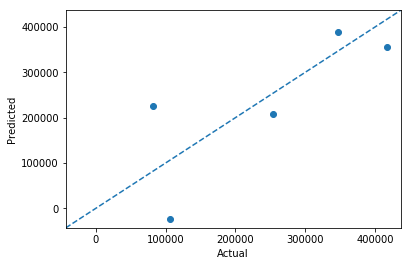

In [72]:
# Error plot
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
plt.scatter(forecast_vals_diff, final_cv_preds)
plt.xlim([min(np.concatenate((forecast_vals_diff, final_cv_preds)) - 20000), 
          max(np.concatenate((forecast_vals_diff, final_cv_preds))) + 20000])
plt.ylim([min(np.concatenate((forecast_vals_diff, final_cv_preds))) - 20000, 
          max(np.concatenate((forecast_vals_diff, final_cv_preds))) + 20000])    
abline(1, 0)
plt.xlabel("Actual")
plt.ylabel("Predicted")

## Next steps

Next steps could include:
- Testing more time-series-specific models: ARIMA, Prophet, RNNs
- Using other regressors from the sklearn library: Ridge, LASSO, SVM, etc. All were initially worse than the linear regression option, but could improve with more data / more tuning.
- Introducing cost data (e.g., CAC)
- Extending the dimensionality of the clustering (e.g., use CLV as well when measuring DTW distance)
- Account for overall macroeconomic environment at each point in time series
- Develop pipeline to identify outliers and replace with interpolated values; the difficulty is figuring out what is a valid data point vs. a non-representative outlier